In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
from jax import grad
from jax import jit, grad, jacfwd, jacrev
from jax.lax import fori_loop
from jax import jit
from functools import partial

import math


import scipy 

import matplotlib.pyplot as plt
import plotly.graph_objects as go

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]
plt.style.use('default')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})


from tqdm import tqdm
import time

from jax.config import config
config.update("jax_enable_x64", True)

import sys
sys.path.append("..")

from Ours import Ours
from FD import FD
from Functions import Quadratic, PyCutestGetter, Ackley
from RBF import RBF
from utils import mse_sensitivity, get_rbfs


from DynamicalSystems import Laser, LaserFull, Monod, invert_Laser_params

%load_ext autoreload
%autoreload 2

# Laser

In [29]:
sigma = 11
alpha = 1
delta = 1.017
gamma = 1e-3
epsilon = 1e-5

final_T = 5e5
dt = 10

x_init = 0.03
y_init = 0.998
z_init = -0.014

normalize_const_diag = jnp.diag(jnp.logspace(0, 3, 11))
gamma_0, gamma_c, gamma_f, I_0, A, s_prime, e, V, k, g, N_t, S_init, N_init, I_init = invert_Laser_params(sigma, alpha, delta, gamma, epsilon, x_init, y_init, z_init)
prmts_0 = normalize_const_diag @ jnp.array([gamma_0, gamma_c, gamma_f, I_0, A, s_prime, e, V, k, g, N_t])
prct_bound = 1e-8 # we look at a neighborhood of +/- p%. 



Fs = [LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=0, noise_type="gaussian", output_var="S"),
      LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=0, noise_type="gaussian", output_var="N"),
      LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=0, noise_type="gaussian", output_var="I")]
sig = 1e-4
Fs_tilde = [LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=sig, noise_type="gaussian", output_var="S"),
            LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=sig, noise_type="gaussian", output_var="N"),
            LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=sig, noise_type="gaussian", output_var="I")]
            

jrandom_key = jrandom.PRNGKey(0)


In [30]:
jrandom_key = jrandom.PRNGKey(1)
jrandom_key, subkey = jrandom.split(jrandom_key)

N_pts = int(1e4)
rbfs = get_rbfs([Fs[0]], prmts_0, N_pts, prct_bound, subkey, smoothing=0)
    

100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1335.40it/s]


In [31]:
p = pts[0]

In [32]:
true_h = 1e-10
grad_getter_cfd_true = FD(sig=0, is_central=True, h=true_h)
true_grad = grad_getter_cfd_true.grad(Fs[0], p, jrandom_key=subkey, H=None)[0]
print(true_grad)

[nan nan nan nan nan nan nan nan nan nan nan]


In [15]:
rbfs[0].f1(p)

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float64)

In [16]:
jnp.linalg.norm(rbfs[0].f1(p) - true_grad)

DeviceArray(nan, dtype=float64)

In [33]:
jrandom_key = jrandom.PRNGKey(2)
jrandom_key, subkey = jrandom.split(jrandom_key)
# sample from uniform distribution
N_pts = int(1e1)
pts_prct = prct_bound*(jrandom.uniform(subkey, shape=(N_pts, 11)) - 0.5)*2
pts = prmts_0.reshape(1, 11)*(1 + pts_prct)
h_space = jnp.logspace(-7, -6, 6)

jrandom_key, subkey = jrandom.split(jrandom_key)
res_fd, res_cfd, res_ours, res_rbf = mse_sensitivity(Fs[0], Fs_tilde[0], sig, pts, rbfs[0], h_space, subkey, num_runs=1)


  0%|                                                    | 0/10 [00:00<?, ?it/s]

19.744701824863736
[-4.84729736 -2.66223341 -2.07341294 -2.0620822  -2.06205824 -2.06205824
 -2.06205797 -2.06130283 -2.01164163 -1.02399451  0.24549864]


 10%|████▍                                       | 1/10 [00:00<00:06,  1.39it/s]

84.39324245476851
[-6.4113913  -1.45952895 -0.12916691 -0.12129536 -0.1212897  -0.1212897
 -0.12128743 -0.1198989  -0.07597043  1.90690759  5.44002442]


 20%|████████▊                                   | 2/10 [00:01<00:05,  1.50it/s]

10.377037844085812
[-11.03441008  -3.70136886  -2.95544678  -2.8105338   -2.81047653
  -2.81047253  -2.81047253  -2.80940769  -2.71881064  -1.06334874
   4.60955032]


 30%|█████████████▏                              | 3/10 [00:02<00:05,  1.33it/s]

8.920859627800974
[ 1.21983859  5.59816883  6.00196202  6.056325    6.05709317  6.05720868
  6.05720868  6.05721171  6.06592407  6.57634583 10.88200887]


 40%|█████████████████▌                          | 4/10 [00:02<00:04,  1.37it/s]

43.47679500544751
[-12.42636168  -9.01150226  -7.35505781  -7.25577571  -7.25362233
  -7.25362151  -7.25362151  -7.25349264  -7.25307371  -7.18789145
  -0.28581595]


 50%|██████████████████████                      | 5/10 [00:03<00:03,  1.39it/s]

3.7350239784831905
[-3.95173319  5.3661877   6.40194505  6.50623373  6.50628766  6.50628766
  6.50647757  6.515165    6.5358095   9.91668536 14.75981823]


 60%|██████████████████████████▍                 | 6/10 [00:04<00:03,  1.30it/s]

4.64746332686075
[-20.29045042  -9.36998878  -9.03816575  -8.64726583  -8.58411109
  -8.58408191  -8.58408191  -8.58407808  -8.58275816  -8.5258385
   4.36591943]


 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.35it/s]

66.47049040827903
[-2.44269104 -0.76611604 -0.47200241 -0.46573899 -0.4657318  -0.46573163
 -0.46573163 -0.46430999 -0.46228556 -0.0367485   1.3840397 ]


 80%|███████████████████████████████████▏        | 8/10 [00:05<00:01,  1.40it/s]

29.573622385554675
[-11.6962399   -3.00800358   0.82065524   2.60900066   2.63823547
   2.63829713   2.63829713   2.63841534   2.63844152   2.83442123
  24.26974818]


 90%|███████████████████████████████████████▌    | 9/10 [00:06<00:00,  1.46it/s]

16.84009777764412
[-4.16141407 -1.34919658 -0.77704853 -0.47908486 -0.40740768 -0.40740768
 -0.40740666 -0.40739872 -0.38116959 -0.2712136   4.56726347]


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


In [34]:
res_rbf

[DeviceArray(2.27017775, dtype=float64),
 DeviceArray(2.33056104, dtype=float64),
 DeviceArray(2.3098538, dtype=float64),
 DeviceArray(2.26474506, dtype=float64),
 DeviceArray(2.34059959, dtype=float64),
 DeviceArray(2.32146828, dtype=float64),
 DeviceArray(2.29875817, dtype=float64),
 DeviceArray(2.4118013, dtype=float64),
 DeviceArray(2.2960874, dtype=float64),
 DeviceArray(2.32146415, dtype=float64)]

In [35]:
res_ours

[[[DeviceArray(308.51156736, dtype=float64)],
  [DeviceArray(194.12503717, dtype=float64)],
  [DeviceArray(127.73835204, dtype=float64)],
  [DeviceArray(103.04445138, dtype=float64)],
  [DeviceArray(77.74126841, dtype=float64)],
  [DeviceArray(85.62078496, dtype=float64)]],
 [[DeviceArray(306.12602821, dtype=float64)],
  [DeviceArray(187.82143659, dtype=float64)],
  [DeviceArray(113.2953096, dtype=float64)],
  [DeviceArray(81.16443902, dtype=float64)],
  [DeviceArray(62.41680291, dtype=float64)],
  [DeviceArray(76.28712425, dtype=float64)]],
 [[DeviceArray(307.68394221, dtype=float64)],
  [DeviceArray(191.75801229, dtype=float64)],
  [DeviceArray(122.55591867, dtype=float64)],
  [DeviceArray(96.02007832, dtype=float64)],
  [DeviceArray(73.56644415, dtype=float64)],
  [DeviceArray(85.88362966, dtype=float64)]],
 [[DeviceArray(304.59336047, dtype=float64)],
  [DeviceArray(184.18325197, dtype=float64)],
  [DeviceArray(104.61270302, dtype=float64)],
  [DeviceArray(68.30600427, dtype=float6

In [36]:
res_fd

[[[DeviceArray(311.69640151, dtype=float64)],
  [DeviceArray(199.16906337, dtype=float64)],
  [DeviceArray(130.50344295, dtype=float64)],
  [DeviceArray(106.08900152, dtype=float64)],
  [DeviceArray(133.16959912, dtype=float64)],
  [DeviceArray(135.95856537, dtype=float64)]],
 [[DeviceArray(311.6939529, dtype=float64)],
  [DeviceArray(199.16787923, dtype=float64)],
  [DeviceArray(130.50652399, dtype=float64)],
  [DeviceArray(106.1009214, dtype=float64)],
  [DeviceArray(133.2168139, dtype=float64)],
  [DeviceArray(136.26730838, dtype=float64)]],
 [[DeviceArray(311.69670915, dtype=float64)],
  [DeviceArray(199.17110443, dtype=float64)],
  [DeviceArray(130.51020963, dtype=float64)],
  [DeviceArray(106.10344544, dtype=float64)],
  [DeviceArray(133.21139967, dtype=float64)],
  [DeviceArray(136.20559021, dtype=float64)]],
 [[DeviceArray(311.69477501, dtype=float64)],
  [DeviceArray(199.16585102, dtype=float64)],
  [DeviceArray(130.49653029, dtype=float64)],
  [DeviceArray(106.07910772, dtype

# Monod

In [62]:
S_init = 10
X_init = 0.1

mu_max = 0.25 # 0.5
Y = 0.75 # 0.5
K_d = 0.03
K_S = 20

dt = 1e-4
final_T = 10

prmts_0 = jnp.array([mu_max, Y, K_S, K_d])

Fs = [Monod(S_init, X_init, dt, final_T, sig=0, output_var="S"),
      Monod(S_init, X_init, dt, final_T, sig=0, output_var="X")]

sig = 1e-4
Fs_tilde = [Monod(S_init, X_init, dt, final_T, sig=sig, output_var="S"),
            Monod(S_init, X_init, dt, final_T, sig=sig, output_var="X")]
            

prct_bound = 0.25 # we look at a neighborhood of +/- p%. 
jrandom_key = jrandom.PRNGKey(0)



In [63]:
jrandom_key = jrandom.PRNGKey(1)
jrandom_key, subkey = jrandom.split(jrandom_key)

N_pts = int(1e3)
rbfs = get_rbfs([Fs[0]], prmts_0, N_pts, prct_bound, subkey, smoothing=0)
    

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 785.48it/s]


In [64]:
jrandom_key = jrandom.PRNGKey(2)
jrandom_key, subkey = jrandom.split(jrandom_key)
# sample from uniform distribution
N_pts = int(1e1)
pts_prct = prct_bound*(jrandom.uniform(subkey, shape=(N_pts, 4)) - 0.5)*2
pts = prmts_0.reshape(1, 4)*(1 + pts_prct)
h_space = jnp.logspace(-1, -3, 6)

jrandom_key, subkey = jrandom.split(jrandom_key)
res_fd, res_cfd, res_ours, res_rbf = mse_sensitivity(Fs[0], Fs_tilde[0], sig, pts, rbfs[0], h_space, subkey, num_runs=1)



  0%|                                                    | 0/10 [00:00<?, ?it/s]

7.622165475167135
[-1.56214505 -0.93094982 -0.24018475  0.20494767]


 10%|████▍                                       | 1/10 [00:00<00:03,  2.58it/s]

15.23714568806294
[-4.17032158 -1.19410144  0.27369441  0.34565233]


 20%|████████▊                                   | 2/10 [00:00<00:02,  2.93it/s]

5.235638806121677
[-0.87056207  0.20467572  0.43782308  1.07160815]


 30%|█████████████▏                              | 3/10 [00:01<00:02,  2.91it/s]

8.50313646839588
[-2.86481611 -0.78653051 -0.33691287  0.88550347]


 40%|█████████████████▌                          | 4/10 [00:01<00:02,  2.88it/s]

169.7239856168245
[-3.80303294 -1.20004528  0.02240716  0.52210584]


 50%|██████████████████████                      | 5/10 [00:01<00:01,  2.94it/s]

45.16483828554948
[-1.56187091 -0.37234268  0.03458157  0.36658208]


 60%|██████████████████████████▍                 | 6/10 [00:02<00:01,  3.05it/s]

4.981922139050557
[-3.21927019 -1.40774    -0.86226805 -0.64619039]


 70%|██████████████████████████████▊             | 7/10 [00:02<00:01,  2.85it/s]

9.012115197735504
[-2.47432416 -1.3750394  -0.27455532  0.5316934 ]


 80%|███████████████████████████████████▏        | 8/10 [00:02<00:00,  2.66it/s]

24.038706709652924
[-2.03614888 -0.65856193 -0.08470293  0.13282992]


 90%|███████████████████████████████████████▌    | 9/10 [00:03<00:00,  2.71it/s]

13.130494517877572
[-1.56938515 -0.452459   -0.11952217  0.31295631]


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.83it/s]


In [65]:
def postprocess(res):
    res = jnp.array(res)
    res = jnp.mean(res, axis=2)
    return jnp.min(jnp.array(res), axis=1)

(array([2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
        1., 0., 2.]),
 array([0.0294095 , 0.1980888 , 0.3667681 , 0.53544741, 0.70412671,
        0.87280601, 1.04148532, 1.21016462, 1.37884392, 1.54752322,
        1.71620253, 1.88488183, 2.05356113, 2.22224044, 2.39091974,
        2.55959904, 2.72827835, 2.89695765, 3.06563695, 3.23431626,
        3.40299556]),
 <BarContainer object of 20 artists>)

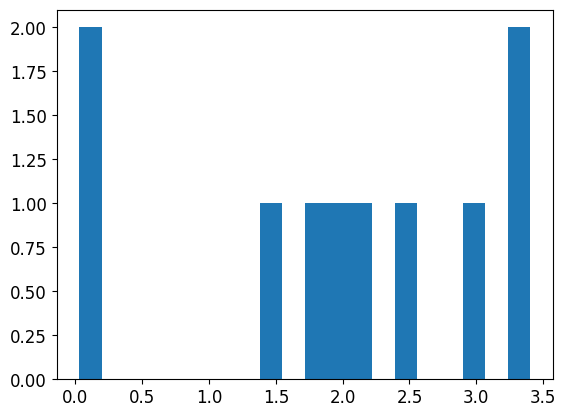

In [66]:
plt.hist([float(c) for c in jnp.log(jnp.array(res_rbf)/postprocess(res_ours))/jnp.log(2)], bins=20)

(array([1., 0., 0., 2., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 1.]),
 array([0.04967354, 0.12799659, 0.20631963, 0.28464267, 0.36296571,
        0.44128875, 0.5196118 , 0.59793484, 0.67625788, 0.75458092,
        0.83290396, 0.911227  , 0.98955005, 1.06787309, 1.14619613,
        1.22451917, 1.30284221, 1.38116526, 1.4594883 , 1.53781134,
        1.61613438]),
 <BarContainer object of 20 artists>)

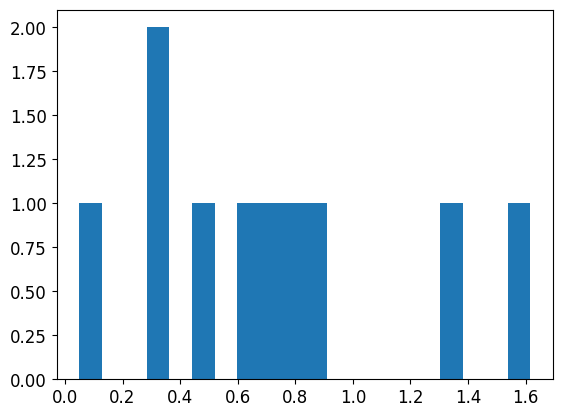

In [67]:
plt.hist([float(c) for c in jnp.log(postprocess(res_fd)/postprocess(res_ours))/jnp.log(2)], bins=20)

(array([1., 0., 0., 0., 1., 0., 1., 0., 0., 4., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 1.]),
 array([-2.70110249, -2.64155986, -2.58201722, -2.52247458, -2.46293195,
        -2.40338931, -2.34384667, -2.28430404, -2.2247614 , -2.16521876,
        -2.10567613, -2.04613349, -1.98659085, -1.92704822, -1.86750558,
        -1.80796294, -1.74842031, -1.68887767, -1.62933503, -1.5697924 ,
        -1.51024976]),
 <BarContainer object of 20 artists>)

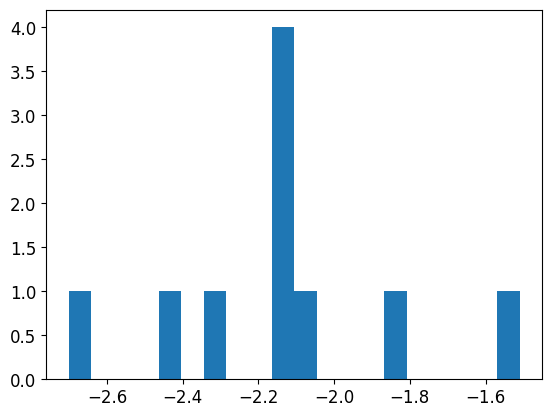

In [68]:
plt.hist([float(c) for c in jnp.log(postprocess(res_cfd)/postprocess(res_ours))/jnp.log(2)], bins=20)

In [ ]:
d